In [10]:
import sys
import os
if not any(path.endswith('textbook') for path in sys.path):
    sys.path.append(os.path.abspath('../../..'))
from textbook_utils import *

(ch:pa_cleaning_pa)=
# Wrangling PurpleAir Sensor Data

In the previous section, we analyzed data from the AQS site `06-067-0010`.
The matching PurpleAir sensor is named `AMTS_TESTINGA`, and we've used
the PurpleAir website to download the data for this sensor into the `data/purpleair_AMTS` folder. 

In [11]:
!ls -alh data/purpleair_AMTS/* | cut -c 1-72

-rw-r--r--  1 nolan  staff    50M Jan 25 16:35 data/purpleair_AMTS/AMTS_
-rw-r--r--  1 nolan  staff    50M Jan 25 16:35 data/purpleair_AMTS/AMTS_
-rw-r--r--  1 nolan  staff    48M Jan 25 16:35 data/purpleair_AMTS/AMTS_
-rw-r--r--  1 nolan  staff    50M Jan 25 16:35 data/purpleair_AMTS/AMTS_


There are four CSV files. Their names are quite long, and the beginning of each of them are identical.
The data dictionary for the PurpleAir data says that each sensor
has two separate instruments, A and B, that each record data.
(Note: The PurpleAir site we used to collect these data (with accompanying data dictionary) has been downgraded. The data are now available through a REST API. The [site that documents the API](https://api.purpleair.com/#api-sensors-get-sensor-data) also contains information about the fields. The topic of REST is covered in {numref}`Chapter %s <ch:web>`.)
Let's examine the later portions of the file names. 

In [12]:
!ls -alh data/purpleair_AMTS/* | cut -c 73-140

TESTING (outside) (38.568404 -121.493163) Primary Real Time 05_20_20
TESTING (outside) (38.568404 -121.493163) Secondary Real Time 05_20_
TESTING B (undefined) (38.568404 -121.493163) Primary Real Time 05_2
TESTING B (undefined) (38.568404 -121.493163) Secondary Real Time 05


We can see that the first two CSV files correspond to the instrument A,
and the last two CSV files correspond to B.
Having two instruments is useful for data cleaning; if A and B disagree about
a measurement, we might question the integrity of the measurement and decide to
remove it.

The data dictionary also mentions that each instrument records Primary and
Secondary data. The Primary data contains the fields we're interested in: PM2.5,
temperature, and humidity. The Secondary data contains data for other particle
sizes, like PM1.0 and PM10. So we work only with the Primary files.

Our tasks are similar to those of the previous section, with the addition of addressing readings from two instruments. 

We begin by loading in the data. 
When CSV files have long names, we can assign the file names into a Python variable
to more easily load the files.

In [13]:
from pathlib import Path

data_folder = Path('data/purpleair_AMTS')
pa_csvs = sorted(data_folder.glob('*.csv'))
pa_csvs[0]

PosixPath('data/purpleair_AMTS/AMTS_TESTING (outside) (38.568404 -121.493163) Primary Real Time 05_20_2018 12_29_2019.csv')

In [14]:
pa_full = pd.read_csv(pa_csvs[0])
pa_full.shape

(672755, 11)

Let's look at the columns to see which ones we need.

In [15]:
pa_full.columns

Index(['created_at', 'entry_id', 'PM1.0_CF1_ug/m3', 'PM2.5_CF1_ug/m3',
       'PM10.0_CF1_ug/m3', 'UptimeMinutes', 'RSSI_dbm', 'Temperature_F',
       'Humidity_%', 'PM2.5_ATM_ug/m3', 'Unnamed: 10'],
      dtype='object')

Although we're interested in PM2.5, it appears there are two columns that
contain PM2.5 data: `PM2.5_CF1_ug/m3` and `PM2.5_ATM_ug/m3`.
We investigate the difference between these two columns to find
that PurpleAir sensors use two different methods to convert a raw laser recording into a PM2.5 number.
These two calculations correspond to the CF1 and ATM columns.
Barkjohn found that using CF1 produced better results than ATM, so we keep that column, 
along with the date, temperature and relative humidity.

In [16]:
def drop_and_rename_cols(df):
    df = df[['created_at', 'PM2.5_CF1_ug/m3', 'Temperature_F', 'Humidity_%']]
    df.columns = ['timestamp', 'PM25cf1', 'TempF', 'RH']
    return df

pa = (pa_full
      .pipe(drop_and_rename_cols))
pa.head()

,timestamp,PM25cf1,TempF,RH
0,2018-05-20 00:00:35 UTC,1.23,83.0,32.0
1,2018-05-20 00:01:55 UTC,1.94,83.0,32.0
2,2018-05-20 00:03:15 UTC,1.80,83.0,32.0
3,2018-05-20 00:04:35 UTC,1.64,83.0,32.0
4,2018-05-20 00:05:55 UTC,1.33,83.0,32.0


Next we check granularity.

## Checking the Granularity

In order for the granularity of these measurements to match the AQS data,
we want one average PM2.5 for each date (a 24-hour period).
PurpleAir states that sensors take measurements every 2 minutes.
Let's double check the granularity of the raw measurements, before we aggregate
them to 24-hour periods.

To do this we convert the column containing the date information from strings
to `pd.TimeStamp` objects. The format of the date is different than the AQS format,
which we describe as '%Y-%m-%d %X %Z'.
As we soon see, `pandas` has special support for data frames with an index of timestamps.

In [17]:
def parse_timestamps(df):
    date_format = '%Y-%m-%d %X %Z'
    times = pd.to_datetime(df['timestamp'], format=date_format)
    return (df.assign(timestamp=times)
            .set_index('timestamp'))

pa = (pa_full
      .pipe(drop_and_rename_cols)
      .pipe(parse_timestamps))
pa.head(2)

,PM25cf1,TempF,RH
timestamp,,,
2018-05-20 00:00:35+00:00,1.23,83.0,32.0
2018-05-20 00:01:55+00:00,1.94,83.0,32.0


Timestamps are tricky---notice that the original timestamps were given in the UTC
timezone. However, the AQS data were averaged according to the *local time in
California*, which is either 7 or 8 hours behind UTC time, depending on whether
daylight saving time is in effect.
This means we need to change the timezone of the PurpleAir timestamps to match
the local timezone. The `df.tz_convert()` method operates on the index of the dataframe, which is one reason
why we set the index of `pa` to the timestamps.

In [18]:
def convert_tz(pa):
    return pa.tz_convert('US/Pacific')

pa = (pa_full
      .pipe(drop_and_rename_cols)
      .pipe(parse_timestamps)
      .pipe(convert_tz))
pa.head(2)

,PM25cf1,TempF,RH
timestamp,,,
2018-05-19 17:00:35-07:00,1.23,83.0,32.0
2018-05-19 17:01:55-07:00,1.94,83.0,32.0


If we compare the first two rows of this version of the data frame to the previous, we see that the time has changed to indicate the seven hour difference from UTC. 

Visualizing timestamps can help us check the granularity of the data. 

### Visualizing Timestamps

One way to visualize timestamps is to count how many appear in each 24-hour
period, then plot those counts over time.
To group time series data in `pandas`, we can use the `df.resample()` method.
This method works on dataframes that have an index of timestamps.
It behaves like `df.groupby()`, except that we can specify how we want the
timestamps to be grouped---we can group into dates, weeks, months, and many
more options. (The `D` argument tells resample to aggregate timestamps into individual dates.)

In [37]:
per_day = (pa.resample('D')
           .size()
           .rename('records_per_day')
           .to_frame()
)

In [39]:
percs = [10, 25, 50, 75, 100]
np.percentile(per_day['records_per_day'], percs, interpolation='lower')

array([ 293,  720, 1075, 1440, 2250])

We see that the number of measurements in a day varies widely. A line plot of these counts gives us a better sense of these variations.

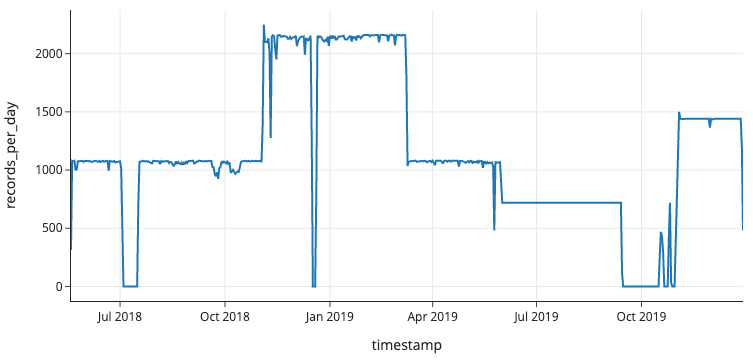

In [12]:
px.line(per_day, x=per_day.index, y='records_per_day',
       width=550, height=250)

This is a fascinating plot. We see clear gaps in the data where there
are no measurements. It appears that significant portions of data in July 2018,
and September 2019 are missing. Even when the sensor appears to be
working, the number of measurements per day is slightly different. For
instance, the plot is "bumpy" between August and October 2018, where dates have a
varying number of measurements. We need to decide what we want to
do with missing data. But perhaps more urgently: there are strange "steps" in the plot.
Some dates have around 1000 readings, some around 2000, some around 700, and some around 1400.
If a sensor takes measurements every 2 minutes, there should be a maximum of 720 measurements
per day. For a perfect sensor, the plot would display a flat line at 720
measurements. This is clearly not the case. Let's investigate.

### Checking the Sampling Rate

Deeper digging reveals that although PurpleAir sensors currently record data
every 120 seconds, this was not always the case. Before May 30, 2019, sensors
recorded data every 80 seconds, or 1080 points a day.
The change in sampling rate does explain the drop at May 30, 2019.
Let's next look at the time periods where there were many more points than expected.
This could mean that some measurements were duplicated in the data.
We can check this by looking at the measurements for one day, say, Jan 1, 2019.
We pass a string into `.loc` to filter timestamps for that date.

In [13]:
len(pa.loc['2019-01-01'])

2154

There are almost double the 1080 expected readings.
Let's check to see if readings are duplicated.

In [14]:
pa.loc['2019-01-01'].index.value_counts()

2019-01-01 13:52:30-08:00    2
2019-01-01 12:02:21-08:00    2
2019-01-01 11:49:01-08:00    2
                            ..
2019-01-01 21:34:10-08:00    2
2019-01-01 11:03:41-08:00    2
2019-01-01 04:05:38-08:00    2
Name: timestamp, Length: 1077, dtype: int64

Each timestamp appears exactly twice, and we can verify that all duplicated dates contain the same PM2.5 reading.
Since this is also
true for both temperature and humidity, we drop the duplicate rows from the data frame.

In [15]:
def drop_duplicate_rows(df):
    return df[~df.index.duplicated()]

pa = (pa_full
      .pipe(drop_and_rename_cols)
      .pipe(parse_timestamps)
      .pipe(convert_tz)
      .pipe(drop_duplicate_rows))
pa.shape

(502628, 3)

To check, we remake the line plot of the number of records for a day, and this time shade in the regions where the counts are supposed to be contained. 

In [16]:
per_day = (pa.resample('D')
 .size().rename('records_per_day')
 .to_frame()
)

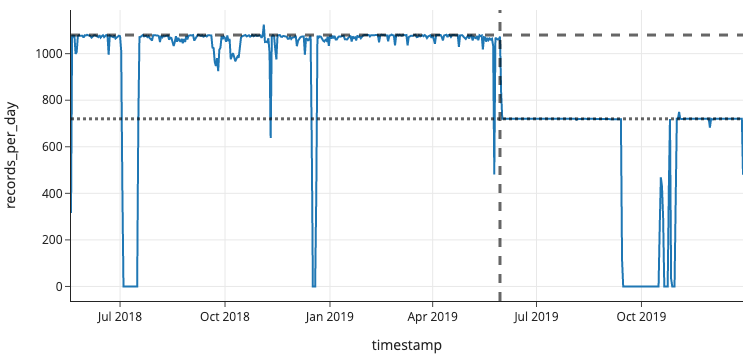

In [37]:
fig = px.line(per_day, x=per_day.index, y='records_per_day',
              width=550, height=250)

fig.add_hline(y=1080, line_width=3, line_dash="dash", opacity=0.6)
fig.add_hline(y=720, line_width=3, line_dash="dot", opacity=0.6)
fig.add_vline(x="2019-05-30", line_width=3, line_dash="dash", opacity=0.6)

fig

After dropping duplicate dates, the plot of measurements per day
looks much more consistent with the the counts we expect.
Careful readers will see two spikes above the maximum measurements around
November of each year when Daylight Saving Time is no longer in effect.
When clocks are rolled back one hour, that day has 25 hours instead of the usual
24 hours. Timestamps are tricky!

But, there's still missing measurements, and we need to decide what to do about them.

## Handling Missing Values

The plan is to create 24-hour averages of the measurements, but we don't want to use days when there are not enough measurements. We follow Barkjohn's analysis, and only keep a 24-hour average if there are at least 90%
of the possible points for that day. Remember that
before May 30, 2019 there are 1080 possible points in a day and after that 720 possible.
We calculate the minimum number of measurements needed to keep a day. 

In [38]:
needed_measurements_80s = 0.9 * 1080
needed_measurements_120s = 0.9 * 720

Now, we can determine which of the days have enough measurements to keep. 

In [39]:
cutoff_date = pd.Timestamp('2019-05-30', tz='US/Pacific')

def has_enough_readings(one_day):
    [n] = one_day
    date = one_day.name
    return (n >= needed_measurements_80s
            if date <= cutoff_date
            else n >= needed_measurements_120s)

In [40]:
should_keep = per_day.apply(has_enough_readings, axis='columns')
should_keep.head()

timestamp
2018-05-19 00:00:00-07:00    False
2018-05-20 00:00:00-07:00     True
2018-05-21 00:00:00-07:00     True
2018-05-22 00:00:00-07:00     True
2018-05-23 00:00:00-07:00     True
Freq: D, dtype: bool

We're ready to average together the readings for each day and then remove the days without enough readings.

In [41]:
def compute_daily_avgs(pa):
    should_keep = (pa.resample('D')
                   ['PM25cf1']
                   .size()
                   .to_frame()
                   .apply(has_enough_readings, axis='columns'))
    return (pa.resample('D')
            .mean()
            .loc[should_keep])

pa = (pa_full
      .pipe(drop_and_rename_cols)
      .pipe(parse_timestamps)
      .pipe(convert_tz)
      .pipe(drop_duplicate_rows)
      .pipe(compute_daily_avgs))
pa.head(2)

,PM25cf1,TempF,RH
timestamp,,,
2018-05-20 00:00:00-07:00,2.48,83.35,28.72
2018-05-21 00:00:00-07:00,3.00,83.25,29.91


Now, we have the average daily PM2.5 readings for instrument A, and we need to repeat the data wrangling we just performed on
instrument A on instrument B. Fortunately, we can reuse the same pipeline. For brevity, we don't include that wrangling here.
But we need to decide what to do if the PM2.5 averages differ. Barkjohn dropped rows if the PM2.5 values for A and B differ by more than 61%, or by more than 5 µg m⁻³. For this pair of sensors, that leads to dropping 12 of the 500+ rows. 

As you can see there is a lot of work to prepare and clean these data: we handled 
missing data, aggregated the readings for each instrument, averaged the readings
together from the two instruments, and removed rows where they disagreed.
This work has given us a set of PM2.5 readings that we are more confident in.
We know that each PM2.5 value in the final data frame is the daily average from
two separate instruments that generated consistent and complete readings.

To fully replicate Barkjohn's analysis, we would need to repeat this process over all the PurpleAir sensors.
Then, we would repeat the AQS cleaning procedure on all the AQS sensors.
Finally, we would merge the PurpleAir and AQS data together.
This procedure produces daily average readings for each collocated sensor pair.
For brevity, we omit this code.
Instead, we proceed with the final steps of the analysis using Berkjohn's dataset.
We begin with an EDA with an eye toward modeling. 